In [14]:
import matplotlib.pyplot as plt
import pandas as pd

from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, auc, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer

from utils import *

In [15]:
data = pd.read_csv('data/train.csv', index_col='id')

data['keyword'] = data.keyword.apply(lambda x: str(x))
data['location'] = data.location.apply(lambda x: str(x))

X_train, X_validation, y_train, y_validation = train_test_split(
    data.drop('target', axis=1), data.target, test_size=0.2
)

In [16]:
def make_categorical_numeric_encoder(feature):
    categorical_numeric_encoder_ct = Pipeline(
        [
            ('t_{}'.format(feature), ColumnTransformer([('t_{}'.format(feature), LeaveOneOutEncoder(), feature)])),
        ]
    )
    return categorical_numeric_encoder_ct

In [17]:
meta_data_encoder = ColumnTransformer(
    [
        ('mean_word_len', FunctionTransformer(lambda x: mean_word_length(x)), 'text'),
        ('tweet_length_t', FunctionTransformer(lambda x: tweet_length(x)), 'text')
    ]
)


text_encoder = Pipeline(
    [
        ('word_tokenizer', ColumnTransformer([('words', FunctionTransformer(get_words), 'text')])),
        ('stop_words_remover', FunctionTransformer(remove_stop_words)),
        ('cleaned_strings', FunctionTransformer(replace_numbers_and_punctuation)),
        ('count_vectorizer', CountVectorizer(ngram_range=(1, 1))),
        ('tfidf', TfidfTransformer(use_idf=True)),
    ]
)

keyword_encoder = make_categorical_numeric_encoder('keyword')
location_encoder = make_categorical_numeric_encoder('keyword')

In [18]:
feature_union_encoder = FeatureUnion(
    [
        ('meta_data_encoded', meta_data_encoder),
        ('text_encoded', text_encoder),
        ('keyword_encoded', keyword_encoder),
        ('location_encoded', location_encoder)
    ]
)

In [19]:
pipeline = Pipeline([
    ('encode_data', feature_union_encoder),
    ('classify', RandomForestClassifier())
])

param_grid = {'classify': [RandomForestClassifier(), GradientBoostingClassifier(), LogisticRegression(max_iter=500), Perceptron(max_iter=500)]}
model = GridSearchCV(pipeline, param_grid)
model.fit(X_train, y_train);

In [20]:
accuracy_score(model.predict(X_validation), y_validation)

0.8089297439264609

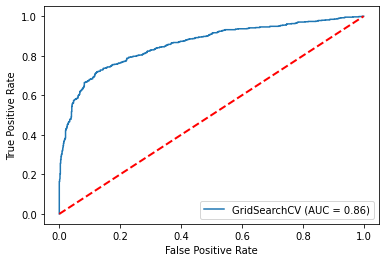

In [21]:
plot_roc_curve(model, X_validation, y_validation)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.show()